In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import joblib

# Import from our codebase
from bind.workflow_utils import ConfigLoader, ModelManager, sample, load_normalization_stats
from vdm.astro_dataset import get_astro_data

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and config to use.

In [2]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type: 'clean' (3-channel joint) or 'triple' (3 separate VDMs)
MODEL_TYPE = 'triple'

# Config file path
if MODEL_TYPE == 'clean':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_aggressive_stellar.ini'
else:
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_triple.ini'

# Number of test samples to visualize
N_SAMPLES = 5

# Number of stochastic realizations per sample
N_REALIZATIONS = 4

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"Device: {DEVICE}")

Model type: triple
Config: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini
Device: cuda


## Load Model and Test Data

In [3]:
# Load configuration
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

[ConfigLoader] Converted legacy_fourier=False to fourier_legacy
[ConfigLoader] conditioning_channels not in config or None, using default: 1
[ConfigLoader] 🌟 Quantile normalization enabled: data/quantile_normalizer_stellar.pkl
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini
[ConfigLoader] Parameters:
  seed: 42
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 42
  num_workers: 40
  cropsize: 128
  max_epochs: 250
  learning_rate: 5e-05
  lr_scheduler: cosine_warmup
  noise_schedule: learned_nn
  gamma_min: -13.3
  gamma_max: 13.0
  data_noise: 0.0005
  antithetic_time_sampling: True
  n_blocks: 5
  embedding_dim: 96
  norm_groups: 8
  n_attention_heads: 8
  large_scale_channels: 3
  use_cross_attention: False
  add_attention: True
  use_fourier_features: True
  legacy_fourier: False
  lambdas: 1.0, 1.0, 1.0
  channel_weights: 1.0, 1.0, 3.0
  use_focal_loss_hyd

In [4]:
# Load model and test dataloader
# ModelManager now supports both 'clean' and 'triple' models automatically
print("\nLoading model and test data...")
print(f"Detected model type: {MODEL_TYPE}")

# Check that checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}")

# ModelManager.initialize() auto-detects model type from config.model_name or checkpoint
# Returns (dataloader_or_datamodule, model)
test_loader, model = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Move model to device
model = model.to(DEVICE)
model.eval()

# Get actual DataLoader from DataModule (for both clean and triple)
actual_loader = test_loader.test_dataloader()
print(f"\n✓ Model loaded successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")

Seed set to 42



Loading model and test data...
Detected model type: triple
[ModelManager] Detected 'triple' model from model_name: triple_vdm_separate_models
[ModelManager] Initializing TRIPLE model (3 separate 1-channel models)...
[ModelManager] Using seed: 42
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs/triple_vdm_separate_models/version_4//checkpoints/epoch=36-step=216117-val/elbo=-5.339.ckpt
[ModelManager] Loaded hyperparameters from checkpoint:
  learning_rate: 5e-05
  weight_decay: 1e-05
  lr_scheduler: cosine_warmup
  n_sampling_steps: 250
  dataset: illustris
  noise_schedule: learned_nn
  gamma_min: -13.3
  gamma_max: 13.0
  antithetic_time_sampling: True
  image_shape: (1, 128, 128)
  data_noise: 0.0005
  lambdas: (1.0, 1.0, 1.0)
  channel_weights: (1.0, 1.0, 3.0)
  hydro_dm_params: None
  gas_params: None
  stars_params: None
  use_focal_loss_hydro_dm: False
  use_focal_loss_gas: False
  use_focal_loss_stars: False
  focal_gamma: 3.0
  use_param_prediction: True
  param_pre

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
[ModelManager] Dataset loaded.
[ModelManager] Dataset loaded.

✓ Model loaded successfully
Test dataset size: 12

✓ Model loaded successfully
Test dataset size: 12


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
# Load normalization statistics
norm_stats = load_normalization_stats()

# Check if using quantile normalization for stars
use_quantile = hasattr(config, 'quantile_path') and config.quantile_path is not None
if use_quantile:
    quantile_path = config.quantile_path
    # Resolve relative path if needed
    if not os.path.isabs(quantile_path):
        quantile_path = str(PROJECT_ROOT / quantile_path)
    quantile_transformer = joblib.load(quantile_path)
    print(f"Using quantile normalization for stars: {quantile_path}")
else:
    quantile_transformer = None
    print(f"Using Z-score normalization for all channels")

✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
Using quantile normalization for stars: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


## Unnormalization Functions

In [6]:
def unnormalize_field(field, channel_idx, norm_stats, quantile_transformer=None):
    """
    Unnormalize a field from normalized space back to physical units.
    
    Args:
        field: Normalized field (can be 2D or higher)
        channel_idx: 0=DM, 1=Gas, 2=Stars
        norm_stats: Dictionary with normalization statistics
        quantile_transformer: Optional quantile transformer for stars
    
    Returns:
        Field in physical units (mass density)
    """
    if channel_idx == 0:  # DM
        mean, std = norm_stats['dm_mag_mean'], norm_stats['dm_mag_std']
    elif channel_idx == 1:  # Gas
        mean, std = norm_stats['gas_mag_mean'], norm_stats['gas_mag_std']
    elif channel_idx == 2:  # Stars
        if quantile_transformer is not None:
            # Quantile inverse transform
            original_shape = field.shape
            field_flat = field.flatten().reshape(-1, 1)
            log_field = quantile_transformer.inverse_transform(field_flat)
            log_field = log_field.reshape(original_shape)
            return 10**log_field - 1
        else:
            mean, std = norm_stats['star_mag_mean'], norm_stats['star_mag_std']
    else:
        raise ValueError(f"Unknown channel index: {channel_idx}")
    
    # Z-score inverse: log_field = field * std + mean
    log_field = field * std + mean
    return 10**log_field - 1


def unnormalize_condition(field, norm_stats):
    """
    Unnormalize DM condition field.
    """
    # Use DM condition stats (different from target DM stats)
    mean = norm_stats.get('dm_condition_mean', norm_stats['dm_mag_mean'])
    std = norm_stats.get('dm_condition_std', norm_stats['dm_mag_std'])
    log_field = field * std + mean
    return 10**log_field - 1

## Load Test Samples and Generate Predictions

In [7]:
# Get a batch of test samples
# test_loader is a DataModule, need to get the actual dataloader
if hasattr(test_loader, 'test_dataloader'):
    actual_loader = test_loader.test_dataloader()
elif hasattr(test_loader, 'val_dataloader'):
    actual_loader = test_loader.val_dataloader()
else:
    actual_loader = test_loader

test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
if len(batch) == 4:
    # (dm_condition, large_scale, target, params)
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

print(f"Conditions shape: {conditions.shape}")
print(f"Targets shape: {targets.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

Conditions shape: torch.Size([1, 4, 128, 128])
Targets shape: torch.Size([1, 3, 128, 128])
Params shape: torch.Size([1, 35])


In [8]:
# Select samples to visualize
sample_indices = list(range(min(N_SAMPLES, conditions.shape[0])))

# Extract selected samples
selected_conditions = conditions[sample_indices]
selected_targets = targets[sample_indices]
selected_params = params[sample_indices] if params is not None else None

print(f"Selected {len(sample_indices)} samples for generation")

Selected 1 samples for generation


In [9]:
# Generate predictions
print(f"Generating {N_REALIZATIONS} realizations per sample...")

# Move model to device
model = model.to(DEVICE)

with torch.no_grad():
    generated = sample(
        model,
        selected_conditions,
        batch_size=N_REALIZATIONS,
        conditional_params=selected_params
    )

print(f"Generated shape: {generated.shape}")
# Shape: (N_SAMPLES, N_REALIZATIONS, 3, H, W)

Generating 4 realizations per sample...


Generating Samples:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:981: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples: 100%|██████████| 1/1 [00:11<00:00, 11.05s/it]

Generated shape: torch.Size([1, 4, 3, 128, 128])


## Visual Comparison: Input → Generated → Ground Truth

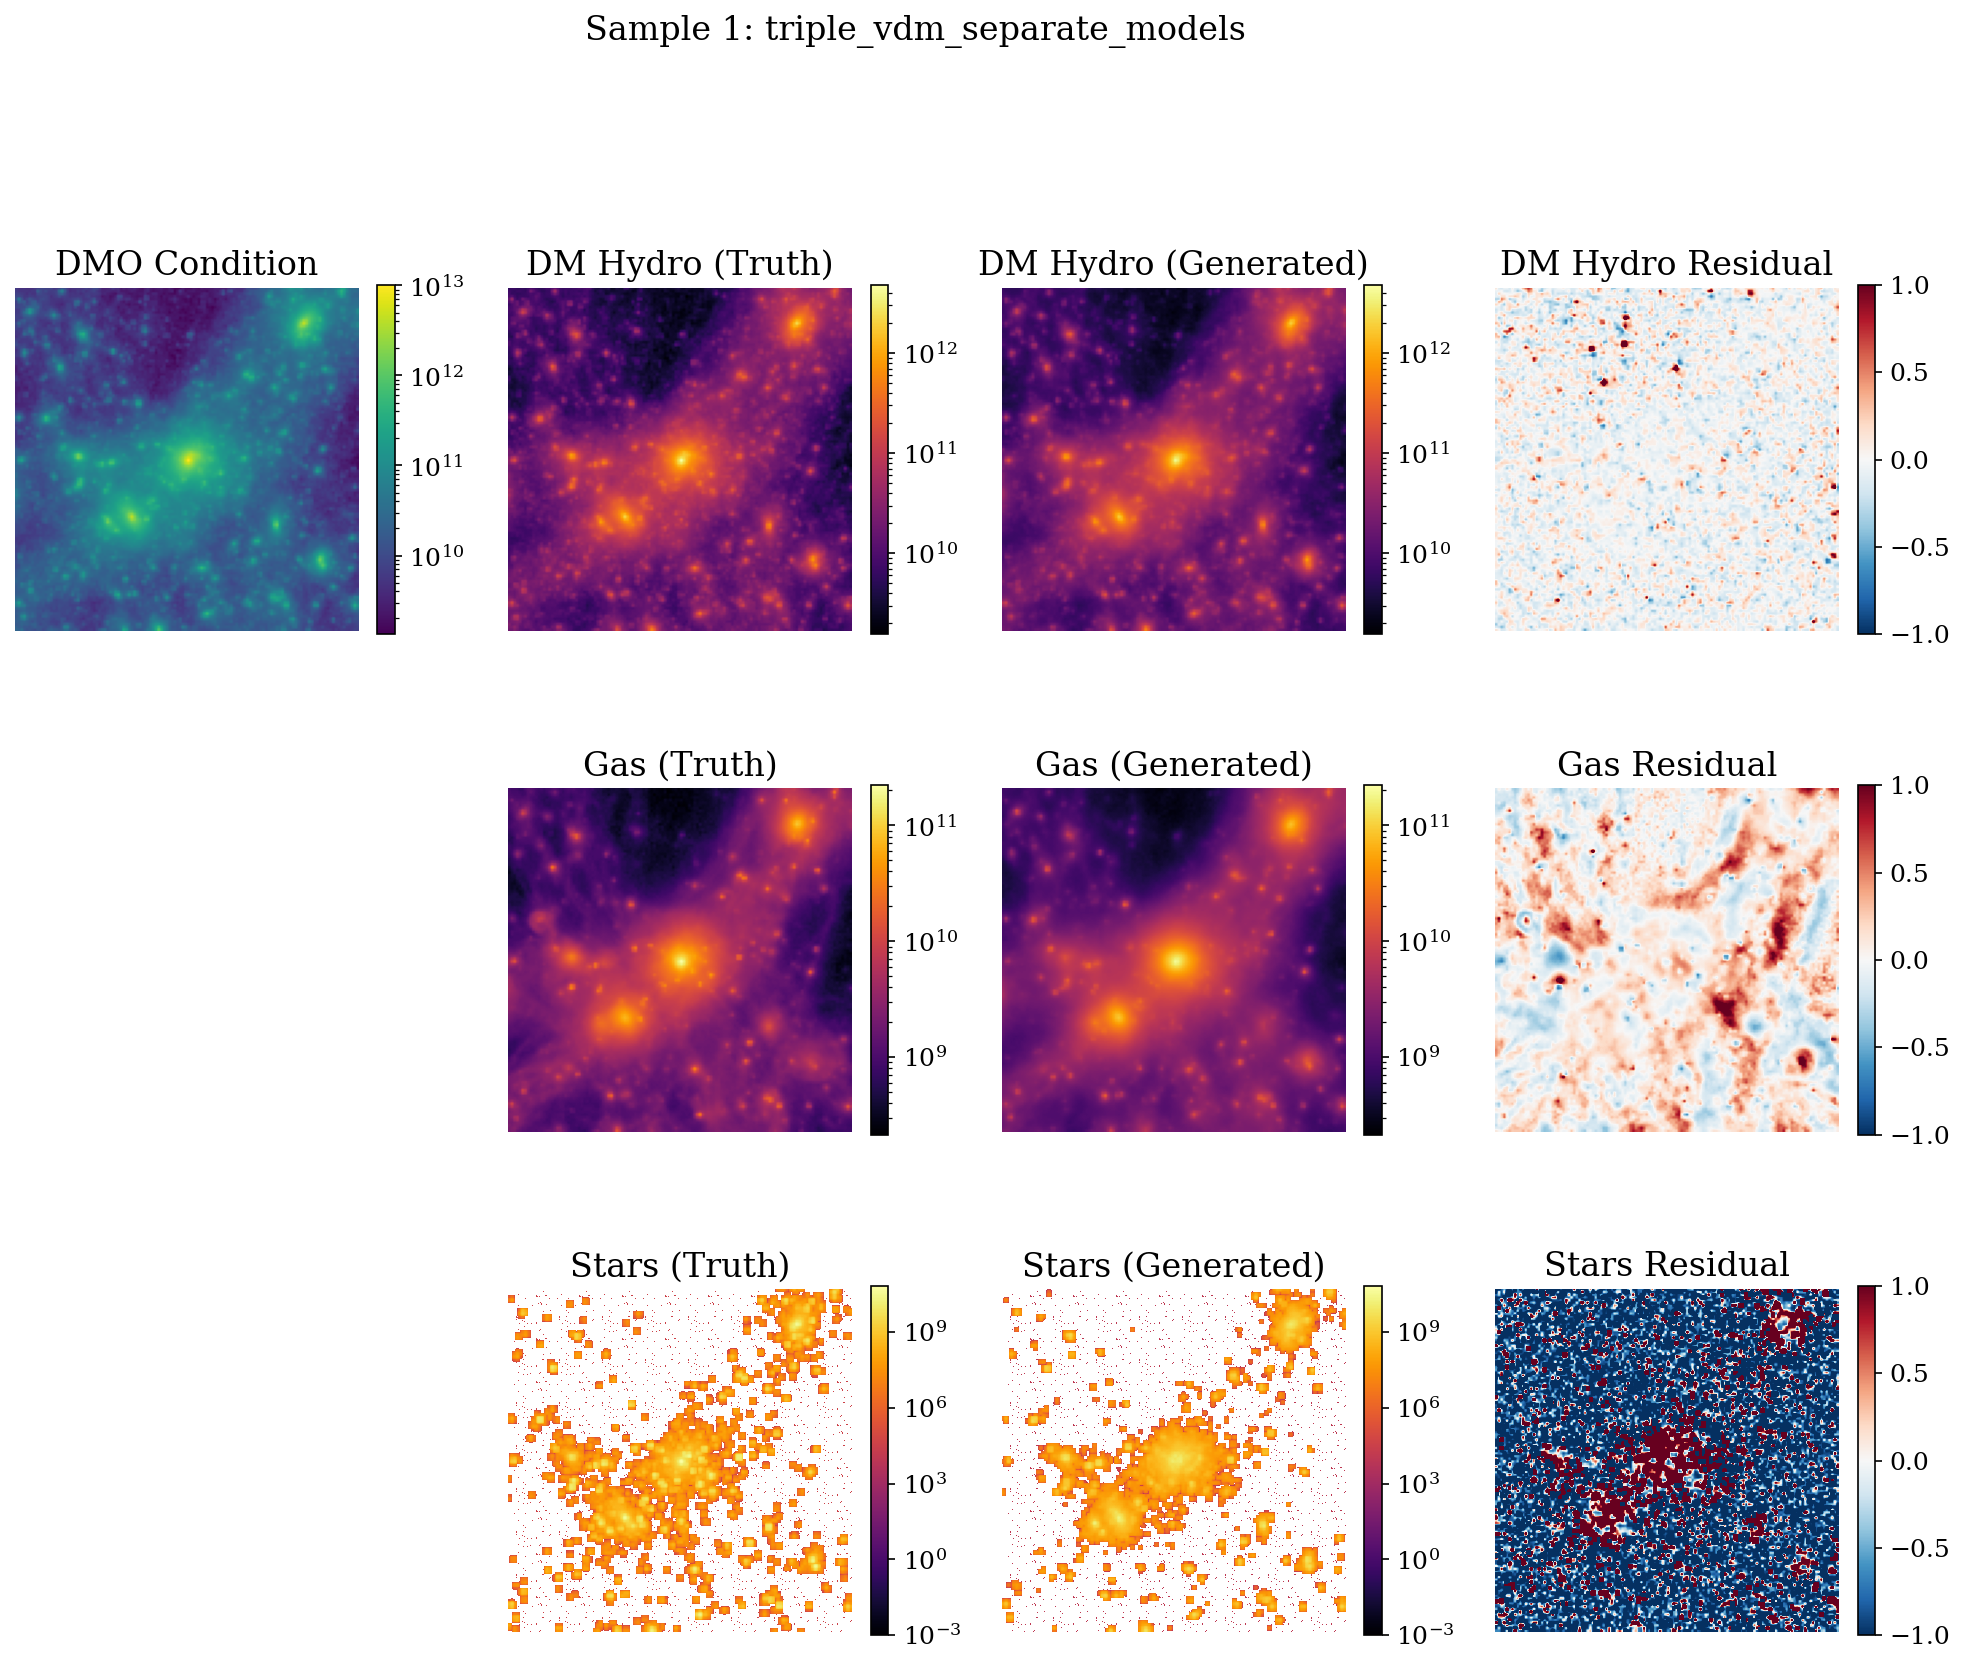


✓ Plotted 1 samples


In [10]:
channel_names = ['DM Hydro', 'Gas', 'Stars']

# Only iterate over actual samples we have
n_samples_to_plot = min(3, len(selected_conditions))

for sample_idx in range(n_samples_to_plot):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get data for this sample
    condition = selected_conditions[sample_idx].numpy()
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()  # Mean over realizations
    gen_std = generated[sample_idx].std(dim=0).numpy()    # Std over realizations
    
    for ch_idx, ch_name in enumerate(channel_names):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Determine color scale
        vmin = max(1e-3, min(target_unnorm.min(), gen_unnorm.min()))
        vmax = max(target_unnorm.max(), gen_unnorm.max())
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
        # Column 1: Condition (only show once, or DM channel)
        if ch_idx == 0:
            ax = fig.add_subplot(gs[ch_idx, 0])
            cond_unnorm = unnormalize_condition(condition[0], norm_stats)
            im = ax.imshow(cond_unnorm, cmap='viridis', norm=LogNorm())
            ax.set_title('DMO Condition')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        else:
            ax = fig.add_subplot(gs[ch_idx, 0])
            ax.axis('off')
        
        # Column 2: Ground Truth
        ax = fig.add_subplot(gs[ch_idx, 1])
        im = ax.imshow(target_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Truth)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 3: Generated (mean)
        ax = fig.add_subplot(gs[ch_idx, 2])
        im = ax.imshow(gen_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Generated)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 4: Residual
        ax = fig.add_subplot(gs[ch_idx, 3])
        residual = (gen_unnorm - target_unnorm) / (target_unnorm + 1e-10)
        im = ax.imshow(residual, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{ch_name} Residual')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Sample {sample_idx + 1}: {config.model_name}', fontsize=16, y=1.02)
    
    # Save figure
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_comparison.png'))
    plt.show()

print(f"\n✓ Plotted {n_samples_to_plot} samples")

## Radial Density Profiles

Compute azimuthally-averaged density profiles around halo centers.

In [15]:
def compute_radial_profile(image, center=None, n_bins=50, r_max=None):
    """
    Compute azimuthally-averaged radial profile.
    
    Args:
        image: 2D array
        center: (y, x) center coordinates. If None, use image center.
        n_bins: Number of radial bins
        r_max: Maximum radius. If None, use half the image size.
    
    Returns:
        r_bins: Radial bin centers
        profile: Mean value in each radial bin
        profile_std: Standard deviation in each radial bin
    """
    ny, nx = image.shape
    
    if center is None:
        center = (ny // 2, nx // 2)
    
    if r_max is None:
        r_max = min(ny, nx) // 2
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Create radial bins
    r_bins = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Compute profile
    profile = np.zeros(n_bins)
    profile_std = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if mask.sum() > 0:
            profile[i] = np.mean(image[mask])
            profile_std[i] = np.std(image[mask])
    
    return r_centers, profile, profile_std

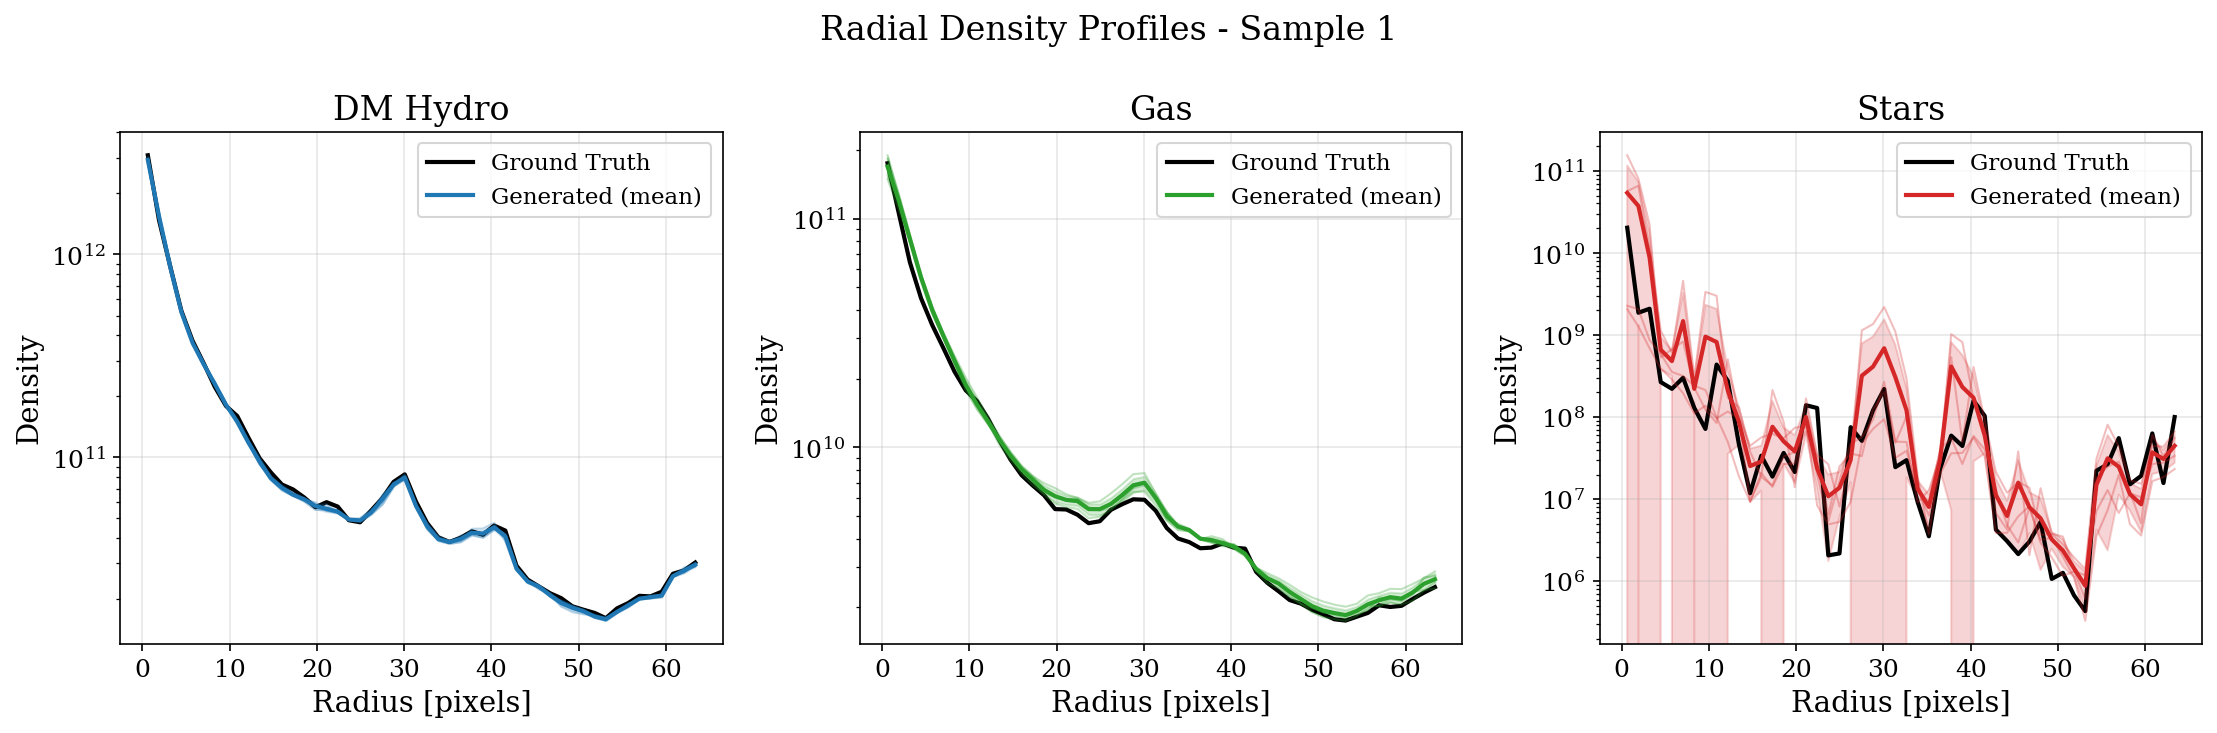

IndexError: index 1 is out of bounds for dimension 0 with size 1

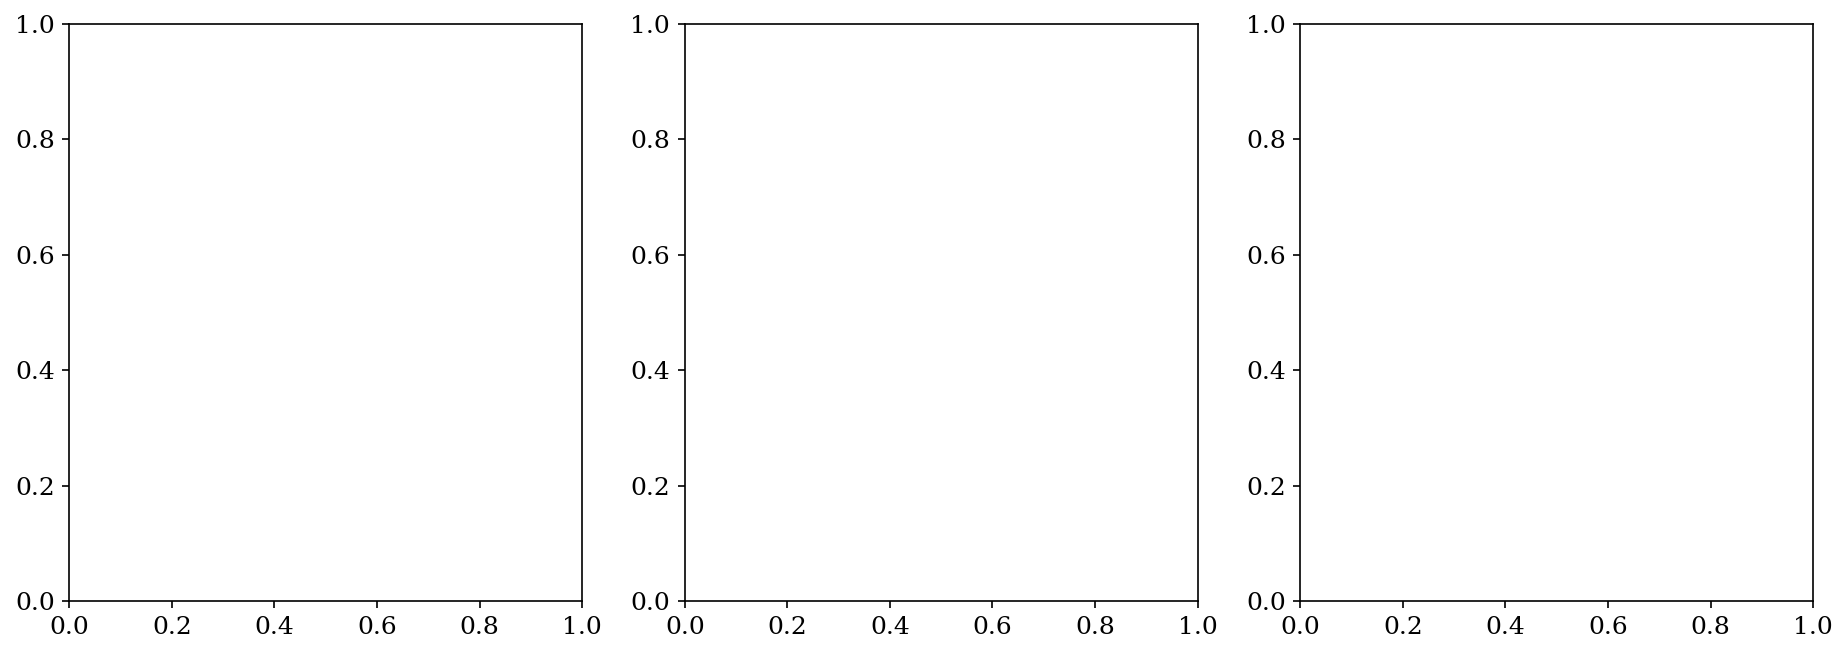

In [16]:
# Compute and plot radial profiles for each sample
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for sample_idx in range(min(3, N_SAMPLES)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    target = selected_targets[sample_idx].numpy()
    gen_samples = generated[sample_idx].numpy()  # (N_REALIZATIONS, 3, H, W)
    
    for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Ground truth profile
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        ax.plot(r, profile_true, 'k-', linewidth=2, label='Ground Truth')
        
        # Generated profiles (multiple realizations)
        gen_profiles = []
        for real_idx in range(N_REALIZATIONS):
            gen_unnorm = unnormalize_field(gen_samples[real_idx, ch_idx], ch_idx, norm_stats, quantile_transformer)
            r, profile_gen, _ = compute_radial_profile(gen_unnorm)
            gen_profiles.append(profile_gen)
            ax.plot(r, profile_gen, '-', color=channel_colors[ch_idx], 
                   alpha=0.3, linewidth=1)
        
        # Mean generated profile
        gen_profiles = np.array(gen_profiles)
        gen_mean = gen_profiles.mean(axis=0)
        gen_std = gen_profiles.std(axis=0)
        
        ax.plot(r, gen_mean, '-', color=channel_colors[ch_idx], 
               linewidth=2, label='Generated (mean)')
        ax.fill_between(r, gen_mean - gen_std, gen_mean + gen_std, 
                       color=channel_colors[ch_idx], alpha=0.2)
        
        ax.set_xlabel('Radius [pixels]')
        ax.set_ylabel('Density')
        ax.set_title(ch_name)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Radial Density Profiles - Sample {sample_idx + 1}', fontsize=16)
    plt.tight_layout()
    
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_profiles.png'))
    plt.show()

## Profile Residuals Analysis

In [17]:
# Aggregate profiles across all samples
all_residuals = {ch: [] for ch in channel_names}

for sample_idx in range(N_SAMPLES):
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()
    
    for ch_idx, ch_name in enumerate(channel_names):
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        _, profile_gen, _ = compute_radial_profile(gen_unnorm)
        
        residual = (profile_gen - profile_true) / (profile_true + 1e-10)
        all_residuals[ch_name].append(residual)

# Convert to arrays
for ch_name in channel_names:
    all_residuals[ch_name] = np.array(all_residuals[ch_name])

IndexError: index 1 is out of bounds for dimension 0 with size 1

AttributeError: 'list' object has no attribute 'mean'

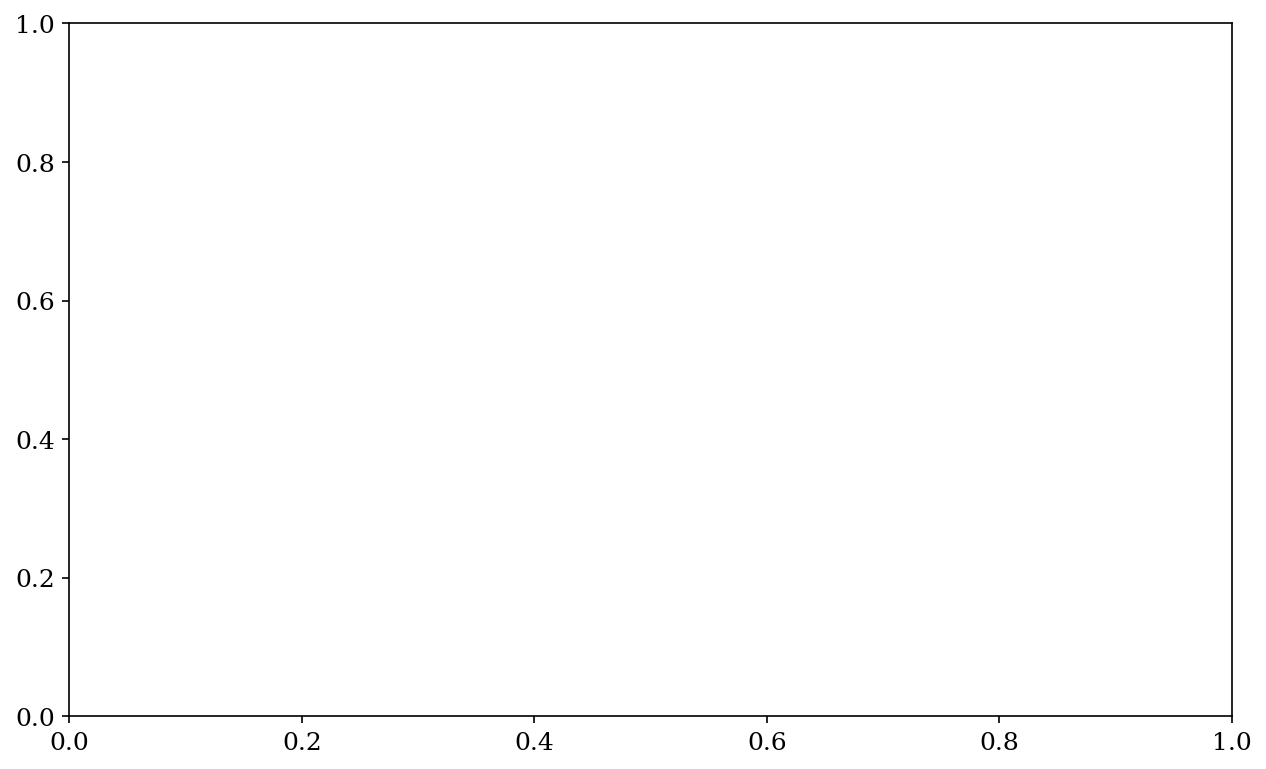

In [24]:
# Plot aggregated residuals
fig, ax = plt.subplots(figsize=(10, 6))

for ch_idx, (ch_name, color) in enumerate(zip(channel_names, channel_colors)):
    residuals = all_residuals[ch_name]
    mean_res = residuals.mean(axis=0)
    std_res = residuals.std(axis=0)
    
    ax.plot(r, mean_res, '-', color=color, linewidth=2, label=ch_name)
    ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                   color=color, alpha=0.2)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Relative Residual (Gen - True) / True')
ax.set_title(f'Radial Profile Residuals - {config.model_name}')
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / f'{config.model_name}_profile_residuals.png'))
plt.show()

## Summary Statistics

In [25]:
print(f"\n{'='*60}")
print(f"Validation Summary: {config.model_name}")
print(f"{'='*60}\n")

print(f"Test samples evaluated: {N_SAMPLES}")
print(f"Realizations per sample: {N_REALIZATIONS}")
print()

print("Mean Absolute Relative Error (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    mare = np.abs(residuals).mean()
    print(f"  {ch_name}: {mare:.4f} ({mare*100:.2f}%)")

print("\nBias (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    bias = residuals.mean()
    print(f"  {ch_name}: {bias:+.4f} ({bias*100:+.2f}%)")


Validation Summary: triple_vdm_separate_models

Test samples evaluated: 5
Realizations per sample: 4

Mean Absolute Relative Error (by channel):
  DM Hydro: 0.3075 (30.75%)
  Gas: 0.2027 (20.27%)
  Stars: 0.4836 (48.36%)

Bias (by channel):


AttributeError: 'list' object has no attribute 'mean'

## Compare Multiple Models (Optional)

In [ ]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = False

if COMPARE_MODELS:
    from vdm.vdm_model_triple import LightTripleVDM
    
    # List of configs to compare: (config_file, label, model_type)
    CONFIGS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'Clean 3ch', 'clean'),
        ('clean_vdm_triple.ini', 'Triple', 'triple'),
    ]
    
    comparison_residuals = {}
    
    for config_file, label, mtype in CONFIGS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
            
        print(f"\nLoading {label}...")
        cfg = ConfigLoader(str(config_path), verbose=False)
        
        # Resolve quantile path
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            if not os.path.isabs(cfg.quantile_path):
                cfg.quantile_path = str(PROJECT_ROOT / cfg.quantile_path)
        
        # Load model based on type
        if mtype == 'triple':
            mdl = LightTripleVDM.load_from_checkpoint(cfg.best_ckpt, map_location=DEVICE)
        else:
            _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
        mdl = mdl.to(DEVICE)
        mdl.eval()
        
        # Generate predictions
        with torch.no_grad():
            gen = sample(mdl, selected_conditions, batch_size=N_REALIZATIONS,
                        conditional_params=selected_params)
        
        # Compute residuals
        residuals = {ch: [] for ch in channel_names}
        for sample_idx in range(N_SAMPLES):
            target = selected_targets[sample_idx].numpy()
            gen_mean = gen[sample_idx].mean(dim=0).numpy()
            
            for ch_idx, ch_name in enumerate(channel_names):
                target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
                gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
                
                r, profile_true, _ = compute_radial_profile(target_unnorm)
                _, profile_gen, _ = compute_radial_profile(gen_unnorm)
                
                residual = (profile_gen - profile_true) / (profile_true + 1e-10)
                residuals[ch_name].append(residual)
        
        comparison_residuals[label] = {ch: np.array(v) for ch, v in residuals.items()}
    
    # Plot comparison
    if comparison_residuals:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
            for label, res_dict in comparison_residuals.items():
                residuals = res_dict[ch_name]
                mean_res = residuals.mean(axis=0)
                ax.plot(r, mean_res, '-', linewidth=2, label=label)
            
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Radius [pixels]')
            ax.set_ylabel('Relative Residual')
            ax.set_title(ch_name)
            ax.set_ylim(-0.5, 0.5)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Model Comparison: Profile Residuals', fontsize=16)
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_profiles.png'))
        plt.show()